In [1]:
import numpy as np, torch, os, multiprocessing, pandas as pd, sys
import torch.backends.cudnn as cudnn, torchio as tio, random
import torch.backends.cudnn as cudnn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
sys.path.append("..")
# from utils.model_res_fu import generate_model
from utils.model_res import generate_model
from tqdm import tqdm   

num_workers = multiprocessing.cpu_count()
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True
random.seed(1234)
torch.manual_seed(1234)
# csv_path = '../NIHSS_score223+NL+AP.csv'
csv_path = '../NIHSS_score223.csv'
basepath_ = '../dataset/S2_data1.5&3.0/'
# basepath_ = '../dataset/S2_data1.5&3.0_seg/'
# S2_weight_stack = '../checkpoint/TEST12.24-01-223_patient_sum_NIHSS_score/mRS - 3dresnet18 - lr_0.01 - CEL --  epoch:16 | vLoss:0.38176 | vAcc:88.3333.pt'
# S2_weight_stack = '../checkpoint/TEST12.27-01-223_patient_sum_NIHSS_score_Nontextdata/mRS - 3dresnet18 - lr_0.01 - CEL --  epoch:47 | vLoss:0.60983 | vAcc:70.0001.pt'
S2_weight_stack = '../checkpoint/TEST12.28-01-223_patient_sum_NIHSS_score_NonSegmentation/mRS - 3dresnet18 - lr_0.01 - CEL --  epoch:27 | vLoss:0.37101 | vAcc:88.3333.pt'
# S2_weight_stack = '../checkpoint/TEST12.29-01-223_patient_sum_NIHSS_score_Nontextdata/mRS - 3dresnet18 - lr_0.01 - CEL --  epoch:68 | vLoss:0.78976 | vAcc:70.0.pt'

In [2]:
def norm_one_zero(table):
    import math
    # print(table)
    for i in table:
        if (i in ['age_norm','gender','onset-to-image(datys)','onset-to-ward(days)','nihss_sum_norm','Out_mRS'])==False:
            # print(i)
            cols_filter = [x for x in table[i] if math.isnan(float(x))==False ]
            med = np.median(cols_filter)
            table[i] = [med if math.isnan(float(x))==True else x for x in table[i]]
            min_cols, max_cols =np.min(cols_filter), np.max(cols_filter)

            normal = lambda x: (x - min_cols)/(max_cols - min_cols)
            table[i] = [normal(x) for x in table[i]]
            table[i] = [0 if math.isnan(float(x))==True else x for x in table[i]]
    # print(table)
    return table
    
table_ =  pd.read_csv(csv_path)
print("table_['Out_mRS']", len(table_['Out_mRS']))
# print(table_.columns.values)
table_label = table_.drop(['ID', 'predict (0-2"good", 3-6"bad")', 'age', '發病日期', 
                                                        '有acute MRA/日期 (2wk內)', '病房日期', 'onset-to-image(有acute-發病日期)',
                                                        'onset-to-ward(病房日期-發病日期)', '入院mRS', 'NIHSS  total', '出院mRS'],axis=1)
# table_label = table_.drop(['ID', 'predict (0-2"good", 3-6"bad")', '1/0: 3T/1.5T MRI', 'A/P', 'N/L','age', '發病日期', 
#                                                        '有acute MRA/日期 (2wk內)', '病房日期', 'onset-to-image(有acute-發病日期)',
#                                                        'onset-to-ward(病房日期-發病日期)', '入院mRS', 'NIHSS  total', '出院mRS'],axis=1)                                                        
print("table_label.columns.values", len(table_label.columns.values))
# print(table_label)
nii_3t_train = sorted([i for i in os.listdir(os.path.join('../dataset/S2_data1.5&3.0/'))])

table_label_norm = norm_one_zero(table_label)
X_train, X_test, y_train, y_test = train_test_split(nii_3t_train, table_label_norm,  stratify=list(table_label['Out_mRS']), test_size=0.25, random_state=123) #seed = 42, 123
# print(y_train)
print('train', ' 0: ', len(y_train['Out_mRS'])-sum(y_train['Out_mRS']),'1:',sum(y_train['Out_mRS']))
print('valid', '0: ', len(y_test['Out_mRS'])-sum(y_test['Out_mRS']), '1:',sum(y_test['Out_mRS']))

table_['Out_mRS'] 222
table_label.columns.values 21
train  0:  90 1: 76
valid 0:  30 1: 26


In [3]:
def tio_process(nii_3t_, table_3t_, basepath_='./dataset/S2_data1.5&3.0/'):
    subjects_ = []
    for  (nii_path, nii_table) in zip(nii_3t_ , table_3t_):
        tb_len = nii_table.shape[-1]
        subject = tio.Subject(
            dwi = tio.ScalarImage(os.path.join(basepath_, nii_path)), 
            mRS = int(nii_table[-1]),
            score= nii_table[0:20])
        subjects_.append(subject)
    return subjects_

In [4]:
def S2_evaluate(model,valid_loader):
    predict_array = {'target':[], 'predict':[]}
    model.eval()
    stream_v = tqdm(valid_loader)
    with torch.no_grad():
        for i, data in enumerate(stream_v, start=1):
            images = data['dwi'][tio.DATA].to(device)
            nihss = data['score'].to(device)
            target = torch.LongTensor(data['mRS']).to(device)
            # print(nihss, target)
            output = model(images).squeeze(1)
            # output = model(images, nihss.to(torch.float32)).squeeze(1)
            output = torch.sigmoid(output)
            # output = (output - output.min()) / (output.max() - output.min() + 1e-8)
            # print(output)
            # _, outputs = torch.max(output, 1)
            predict_array['predict'].append(np.array(output.cpu()))
            predict_array['target'].append(target.item())
    return predict_array
    
if True:
    test_transform = tio.Compose([])
    S2_reply = []
    model = generate_model(model_depth=18, n_input_channels=1, n_classes=2)
    checkpoint = torch.load(S2_weight_stack, map_location=torch.device(device))
    model.load_state_dict(checkpoint['model_state_dict'])

    model.to(device)
    # //////////////////////////////////////////////////
    validation_subjects = tio_process(X_test, np.array(y_test), basepath_ = basepath_)
    # validation_subjects = tio_process(X_test, np.array(y_test), basepath_ = '../dataset/S2_data1.5&3.0_seg/')
    validation_set = tio.SubjectsDataset(validation_subjects, transform=test_transform)
    valid_loader = torch.utils.data.DataLoader(validation_set, batch_size=1,  shuffle=False, num_workers=2)
    S2_reply.append(S2_evaluate(model, valid_loader))

100%|██████████| 56/56 [00:27<00:00,  2.00it/s]


In [5]:
pred_table = pd.DataFrame([], columns=['ID', 'Ground Truth', 'Predict 0-3', 'Predict 3-6'])
pred_table

,ID,Ground Truth,Predict 0-3,Predict 3-6


In [6]:
for g,p,d in zip(S2_reply[0]['target'], S2_reply[0]['predict'] , validation_subjects):
    p_0 = p[0][0]
    p_1 = p[0][1]
    ID = d['dwi']['path'].replace(basepath_,'')
    new_user = pd.DataFrame([[ID, g, p_0, p_1]], columns=['ID', 'Ground Truth', 'Predict 0-3', 'Predict 3-6'])
    pred_table = pred_table.append(new_user)

In [7]:
temp = list(pred_table['Predict 3-6']>0.5)
temp = [int(x) for x in temp]
pred_table['Predict_Result'] = temp
# pred_table.to_csv('./Only MRI image - patient222.csv')
# pred_table.to_csv('./Fusion_model - patient222.csv')
pred_table.head()

,ID,Ground Truth,Predict 0-3,Predict 3-6,Predict_Result
0,is0317.nii.gz,1,0.335039,0.637591,1
0,is0232.nii.gz,1,0.058540,0.926400,1
0,is0184.nii.gz,0,0.684941,0.316477,0
0,is0265.nii.gz,1,0.066057,0.918560,1
0,is0152.nii.gz,0,0.629007,0.358032,0


In [8]:

GT =np.array(pred_table['Ground Truth'])
SR = np.array(pred_table['Predict_Result'])
TP = int((SR * GT).sum()) #TP
FN = int((GT * (1-SR)).sum()) #FN
TN = int(((1-GT) * (1-SR)).sum()) #TN
FP = int(((1-GT) * SR).sum()) #FP
print(f'Accuracy  :', round((TP + TN)/(TP + TN + FP + FN), 2)*100, '%')
print(f'Sensitivity  :', round(float(TP)/(float(TP+FN) + 1e-6), 5))
print(f'Specificity  :', round(float(TN)/(float(TN+FP) + 1e-6), 5))

Accuracy  : 88.0 %
Sensitivity  : 0.84615
Specificity  : 0.9


In [9]:
def CI(y_pred, y_true):
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return confidence_lower, confidence_upper

In [10]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(np.array(pred_table['Ground Truth']).astype(np.int8), np.array(pred_table['Predict 3-6']))
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc, '[',CI(np.array(pred_table['Predict 3-6']),np.array(pred_table['Ground Truth']).astype(np.int8)),']')

0.908974358974359 [ (0.8307692307692308, 0.9789196310935441) ]


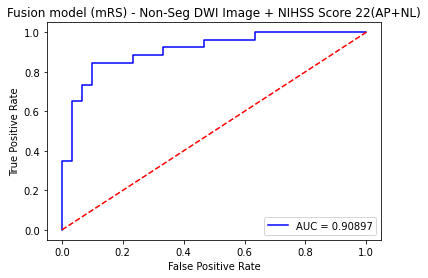

In [11]:
import matplotlib.pyplot as plt
plt.title('Fusion model (mRS) - Non-Seg DWI Image + NIHSS Score 22(AP+NL)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()